Calculating Theoretical Variance Limit...
199.39075695202007

Starting Simulations...


Sparse Super: 100%|██████████████████████████| 500/500 [00:04<00:00, 111.89it/s]



Generating plots for Dense regime...


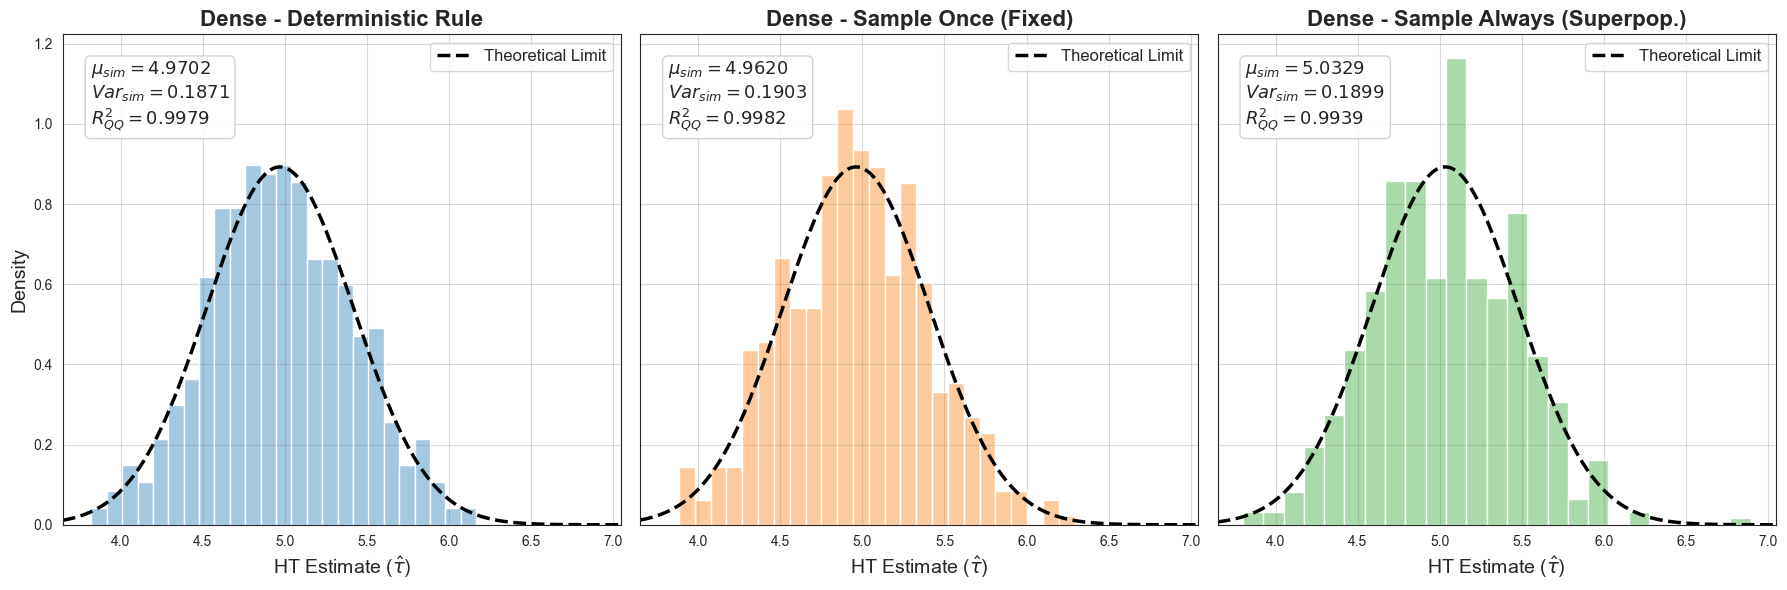


Generating plots for Sparse regime...


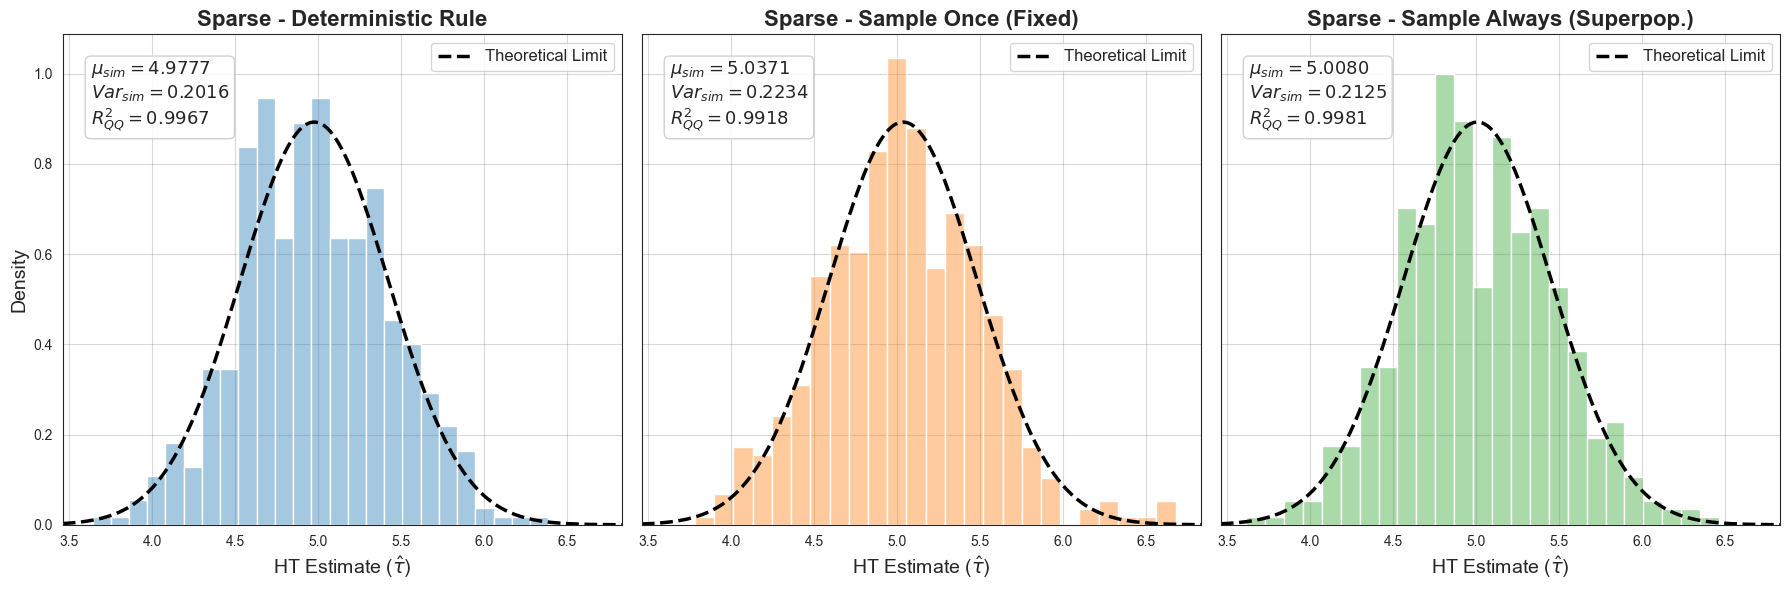


All processing complete.


In [10]:
# Base code generated by Gemini Pro. 1/30/2026.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# --- Configuration ---
SEED = 519          
N = 1000            
n_sims = 500 # In paper, we used 10,000.    
pi = 0.5            
rho_sparse_factor = N**(-0.3) 

np.random.seed(SEED)

# --- Potential Outcome Function ---
def get_potential_outcome(u, w, r):
    alpha = u
    tau = 1.0 + 4.0 * u
    beta = 2.0 + 2.0 * u
    gamma = 5.0
    delta = 4.0
    
    y = alpha + (tau * w) + (beta * r) + (gamma * r**2) + (delta * w * r)
    return y

def horvitz_thompson(adj, w, u, pi):
    # Avoid division by zero in sparse case for isolated nodes (though unlikely with N^-0.3)
    degrees = np.maximum(adj.sum(axis=1), 1)
    r_vector = (adj @ w) / degrees
    y_obs = get_potential_outcome(u, w, r_vector)
    weights = (w / pi) - ((1 - w) / (1 - pi))
    return np.mean(weights * y_obs)

# --- Theoretical Limit Calculation ---
def calculate_limit_variance(pi, n_theory=1000000):
    u = np.random.rand(n_theory)
    delta = 4.0
    
    y1 = get_potential_outcome(u,1,pi)
    y0 = get_potential_outcome(u,0,pi)
    
    R = (y1 / pi) + (y0 / (1 - pi))
    Q = -delta * np.log(np.maximum(1 - u, 1e-10))
    second_moment = np.mean((R + Q)**2)
    var_limit = pi * (1 - pi) * second_moment
    return var_limit

# --- Generators ---
def generate_deterministic_setup(n):
    u = np.arange(1, n + 1) / n
    i, j = np.indices((n, n)) + 1
    adj = ((i + j) > n).astype(float)
    np.fill_diagonal(adj, 0)
    return adj, u

def generate_deterministic_sparse_setup(n, rho):
    adj_dense, u = generate_deterministic_setup(n)
    rand_mat = np.random.rand(n, n)
    mask = (rand_mat <= rho).astype(float)
    mask = np.triu(mask, 1)
    mask = mask + mask.T
    return adj_dense * mask, u

def generate_random_graphon_setup(n, rho):
    u = np.random.rand(n)
    U_col, U_row = u[:, np.newaxis], u[np.newaxis, :]
    W_mat = (U_col + U_row > 1.0).astype(float)
    P_edge = rho * W_mat
    rand_mat = np.random.rand(n, n)
    adj = (rand_mat <= P_edge).astype(float)
    adj = np.triu(adj, 1)
    adj = adj + adj.T
    return adj, u

# --- Main Simulation ---
print(f"Calculating Theoretical Variance Limit...")
var_limit_theory = calculate_limit_variance(pi)
print(calculate_limit_variance(pi))

results = {
    "Dense": {"Det": [], "Fixed": [], "Super": []},
    "Sparse": {"Det": [], "Fixed": [], "Super": []}
}

print(f"\nStarting Simulations...")

# --- DENSE SIMULATIONS ---
rho_d = 1.0

# 1. Deterministic
adj_det, u_det = generate_deterministic_setup(N)
for _ in tqdm(range(n_sims), desc="Dense Det"):
    w = np.random.binomial(1, pi, N)
    results["Dense"]["Det"].append(horvitz_thompson(adj_det, w, u_det, pi))

# 2. Sample Once
adj_fixed, u_fixed = generate_random_graphon_setup(N, rho_d)
for _ in tqdm(range(n_sims), desc="Dense Fixed"):
    w = np.random.binomial(1, pi, N)
    results["Dense"]["Fixed"].append(horvitz_thompson(adj_fixed, w, u_fixed, pi))

# 3. Sample Always
for _ in tqdm(range(n_sims), desc="Dense Super"):
    adj_super, u_super = generate_random_graphon_setup(N, rho_d)
    w = np.random.binomial(1, pi, N)
    results["Dense"]["Super"].append(horvitz_thompson(adj_super, w, u_super, pi))


# --- SPARSE SIMULATIONS ---
rho_s = rho_sparse_factor

# 1. Deterministic (Sparse version)
adj_det_s, u_det_s = generate_deterministic_sparse_setup(N, rho_s)
for _ in tqdm(range(n_sims), desc="Sparse Det"):
    w = np.random.binomial(1, pi, N)
    results["Sparse"]["Det"].append(horvitz_thompson(adj_det_s, w, u_det_s, pi))

# 2. Sample Once
adj_fixed_s, u_fixed_s = generate_random_graphon_setup(N, rho_s)
for _ in tqdm(range(n_sims), desc="Sparse Fixed"):
    w = np.random.binomial(1, pi, N)
    results["Sparse"]["Fixed"].append(horvitz_thompson(adj_fixed_s, w, u_fixed_s, pi))

# 3. Sample Always
for _ in tqdm(range(n_sims), desc="Sparse Super"):
    adj_super_s, u_super_s = generate_random_graphon_setup(N, rho_s)
    w = np.random.binomial(1, pi, N)
    results["Sparse"]["Super"].append(horvitz_thompson(adj_super_s, w, u_super_s, pi))


# --- PLOTTING SECTION ---
sns.set_style("white") 

# Configuration
TEXT_FONTSIZE = 13  
LEGEND_FONTSIZE = 12 
TITLE_FONTSIZE = 16  
AXIS_LABEL_SIZE = 14
BINS = 25 # Larger bins as requested

regimes = ["Dense", "Sparse"]

for regime in regimes:
    print(f"\nGenerating plots for {regime} regime...")
    
    # Retrieve data for this regime
    data_det = np.array(results[regime]["Det"])
    data_fixed = np.array(results[regime]["Fixed"])
    data_super = np.array(results[regime]["Super"])
    
    # Calculate Axis Limits specific to this regime (Shared across the 3 plots)
    all_data = np.concatenate([data_det, data_fixed, data_super])
    global_min = np.min(all_data)
    global_max = np.max(all_data)
    x_buffer = (global_max - global_min) * 0.05
    xlims = (global_min - x_buffer, global_max + x_buffer)
    
    # Setup Figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    plots_config = [
        (axes[0], data_det, "Deterministic Rule", '#1f77b4'),       # Blue
        (axes[1], data_fixed, "Sample Once (Fixed)", '#ff7f0e'),    # Orange
        (axes[2], data_super, "Sample Always (Superpop.)", '#2ca02c') # Green
    ]
    
    for ax, data, title, color in plots_config:
        mean_val = np.mean(data)
        var_val = np.var(data)
        var_theory_N = var_limit_theory / N
        std_theory_N = np.sqrt(var_theory_N)

        _, fit_params = stats.probplot(data, dist="norm", fit=True)
        r_squared = fit_params[2] ** 2
        
        # Histogram
        sns.histplot(data, ax=ax, kde=False, stat="density", 
                     color=color, alpha=0.4, edgecolor="white", bins=BINS)
        
        # Theoretical Normal Curve
        x = np.linspace(xlims[0], xlims[1], 200)
        p = (1 / (std_theory_N * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_val) / std_theory_N) ** 2)
        ax.plot(x, p, 'k--', linewidth=2.5, label='Theoretical Limit')
        
        # Styling
        ax.set_title(f"{regime} - {title}", fontsize=TITLE_FONTSIZE, fontweight='bold')
        ax.set_xlabel(r"HT Estimate ($\hat{\tau}$)", fontsize=AXIS_LABEL_SIZE)
        ax.legend(loc='upper right', fontsize=LEGEND_FONTSIZE)
        
        # Subtle Grid Lines
        ax.grid(True, linestyle='-', alpha=0.3, color='gray') 
        ax.set_xlim(xlims) 
        
        # Stats Box
        textstr = '\n'.join((
            r'$\mu_{sim}=%.4f$' % (mean_val, ),
            r'$Var_{sim}=%.4f$' % (var_val, ),
            r'$R^2_{QQ}=%.4f$' % (r_squared, )))
            
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='0.8')
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=TEXT_FONTSIZE,
                verticalalignment='top', bbox=props, family='monospace')

    # Y-label only on the first plot
    axes[0].set_ylabel("Density", fontsize=AXIS_LABEL_SIZE)
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    plt.tight_layout()
    filename = f"{regime.lower()}_results"
    # print(f"Saving {filename}.pdf...")
    # plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    # plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print("\nAll processing complete.")